## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 預防錯誤： OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

# 三層隱藏層，一個輸出層(softmax)
def build_mlp(input_shape, output_units=10, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    x = keras.layers.Dense(units=512, activation="relu", name="hidden_layer_0")(input_layer)
    x = BatchNormalization()(x)
    x = keras.layers.Dense(units=256, activation="relu", name="hidden_layer_1")(x)
    x = BatchNormalization()(x)
    x = keras.layers.Dense(units=128, activation="relu", name="hidden_layer_2")(x)
    x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 20 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

```
keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
```

- factor: factor by which the learning rate will be reduced. new_lr = lr * factor
- patience: number of epochs with no improvement after which learning rate will be reduced

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.3, 0.5]
redice_lr_patient = [3, 5]

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 12s 234us/step - loss: 1.1643 - acc: 0.5996 - val_loss: 1.4817 - val_acc: 0.4838
Epoch 17/20
50000/50000 [==============================] - 12s 233us/step - loss: 1.1388 - acc: 0.6085 - val_loss: 1.4773 - val_acc: 0.4869
Epoch 18/20
50000/50000 [==============================] - 12s 236us/step - loss: 1.1196 - acc: 0.6159 - val_loss: 1.4725 - val_acc: 0.4870
Epoch 19/20
50000/50000 [==============================] - 12s 233us/step - loss: 1.0966 - acc: 0.6255 - val_loss: 1.4720 - val_acc: 0.4858
Epoch 20/20
50000/50000 [==============================] - 12s 232us/step - loss: 1.0740 - acc: 0.6317 - val_loss: 1.4805 - val_acc: 0.4858
Numbers of exp: 2, reduce_factor: 0.30, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
________________________________________________________

50000/50000 [==============================] - 12s 232us/step - loss: 1.2434 - acc: 0.5696 - val_loss: 1.4849 - val_acc: 0.4738
Epoch 14/20
50000/50000 [==============================] - 12s 235us/step - loss: 1.2197 - acc: 0.5765 - val_loss: 1.4754 - val_acc: 0.4780
Epoch 15/20
50000/50000 [==============================] - 12s 234us/step - loss: 1.1950 - acc: 0.5877 - val_loss: 1.4685 - val_acc: 0.4806
Epoch 16/20
50000/50000 [==============================] - 12s 231us/step - loss: 1.1724 - acc: 0.5953 - val_loss: 1.4707 - val_acc: 0.4847
Epoch 17/20
50000/50000 [==============================] - 12s 233us/step - loss: 1.1499 - acc: 0.6046 - val_loss: 1.4597 - val_acc: 0.4898
Epoch 18/20
50000/50000 [==============================] - 12s 234us/step - loss: 1.1265 - acc: 0.6136 - val_loss: 1.4644 - val_acc: 0.4882
Epoch 19/20
50000/50000 [==============================] - 12s 234us/step - loss: 1.1056 - acc: 0.6195 - val_loss: 1.4458 - val_acc: 0.4928
Epoch 20/20
50000/50000 [=======

50000/50000 [==============================] - 13s 253us/step - loss: 1.4623 - acc: 0.4912 - val_loss: 1.6072 - val_acc: 0.4402
Epoch 10/20
50000/50000 [==============================] - 12s 245us/step - loss: 1.4364 - acc: 0.5024 - val_loss: 1.5968 - val_acc: 0.4393
Epoch 11/20
50000/50000 [==============================] - 12s 246us/step - loss: 1.4124 - acc: 0.5110 - val_loss: 1.5792 - val_acc: 0.4463
Epoch 12/20
50000/50000 [==============================] - 12s 244us/step - loss: 1.3881 - acc: 0.5197 - val_loss: 1.5707 - val_acc: 0.4454
Epoch 13/20
50000/50000 [==============================] - 12s 244us/step - loss: 1.3659 - acc: 0.5281 - val_loss: 1.5602 - val_acc: 0.4513
Epoch 14/20
50000/50000 [==============================] - 12s 244us/step - loss: 1.3445 - acc: 0.5357 - val_loss: 1.5561 - val_acc: 0.4544
Epoch 15/20
50000/50000 [==============================] - 12s 243us/step - loss: 1.3249 - acc: 0.5414 - val_loss: 1.5426 - val_acc: 0.4576
Epoch 16/20
50000/50000 [=======

50000/50000 [==============================] - 14s 278us/step - loss: 2.3415 - acc: 0.2319 - val_loss: 2.3652 - val_acc: 0.2285
Epoch 5/20
50000/50000 [==============================] - 14s 278us/step - loss: 2.2816 - acc: 0.2461 - val_loss: 2.3102 - val_acc: 0.2408
Epoch 6/20
50000/50000 [==============================] - 14s 280us/step - loss: 2.2356 - acc: 0.2571 - val_loss: 2.2678 - val_acc: 0.2513
Epoch 7/20
50000/50000 [==============================] - 14s 278us/step - loss: 2.1962 - acc: 0.2683 - val_loss: 2.2344 - val_acc: 0.2582
Epoch 8/20
50000/50000 [==============================] - 14s 278us/step - loss: 2.1641 - acc: 0.2776 - val_loss: 2.2055 - val_acc: 0.2673
Epoch 9/20
50000/50000 [==============================] - 14s 278us/step - loss: 2.1356 - acc: 0.2841 - val_loss: 2.1784 - val_acc: 0.2761
Epoch 10/20
50000/50000 [==============================] - 14s 279us/step - loss: 2.1087 - acc: 0.2905 - val_loss: 2.1554 - val_acc: 0.2817
Epoch 11/20
50000/50000 [============

50000/50000 [==============================] - 20s 402us/step - loss: 2.7405 - acc: 0.1429 - val_loss: 2.5433 - val_acc: 0.1910
Epoch 2/20
50000/50000 [==============================] - 14s 275us/step - loss: 2.4400 - acc: 0.2061 - val_loss: 2.3964 - val_acc: 0.2247
Epoch 3/20
50000/50000 [==============================] - 14s 275us/step - loss: 2.3211 - acc: 0.2349 - val_loss: 2.3102 - val_acc: 0.2449
Epoch 4/20
50000/50000 [==============================] - 14s 273us/step - loss: 2.2488 - acc: 0.2507 - val_loss: 2.2505 - val_acc: 0.2609
Epoch 5/20
50000/50000 [==============================] - 14s 276us/step - loss: 2.1955 - acc: 0.2648 - val_loss: 2.2050 - val_acc: 0.2669
Epoch 6/20
50000/50000 [==============================] - 14s 276us/step - loss: 2.1542 - acc: 0.2755 - val_loss: 2.1687 - val_acc: 0.2743
Epoch 7/20
50000/50000 [==============================] - 14s 273us/step - loss: 2.1187 - acc: 0.2858 - val_loss: 2.1407 - val_acc: 0.2827
Epoch 8/20
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 21s 420us/step - loss: 2.7910 - acc: 0.1348 - val_loss: 2.6072 - val_acc: 0.1859
Epoch 2/20
50000/50000 [==============================] - 14s 278us/step - loss: 2.4303 - acc: 0.2006 - val_loss: 2.4059 - val_acc: 0.2158
Epoch 3/20
50000/50000 [==============================] - 14s 277us/step - loss: 2.2957 - acc: 0.2347 - val_loss: 2.3048 - val_acc: 0.2357
Epoch 4/20
50000/50000 [==============================] - 14s 277us/step - loss: 2.2156 - acc: 0.2545 - val_loss: 2.2327 - val_acc: 0.2580
Epoch 5/20
50000/50000 [==============================] - 14s 279us/step - loss: 2.1591 - acc: 0.2709 - val_loss: 2.1778 - val_acc: 0.2710
Epoch 6/20
50000/50000 [==============================] - 14s 277us/step - loss: 2.1159 - acc: 0.2823 - val_loss: 2.1389 - val_acc: 0.2834
Epoch 7/20
50000/50000 [==============================] - 14s 279us/step - loss: 2.0819 - acc: 0.2924 - val_loss: 2.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 20s 401us/step - loss: 1.9395 - acc: 0.3343 - val_loss: 1.9877 - val_acc: 0.3463
Epoch 2/20
50000/50000 [==============================] - 13s 266us/step - loss: 1.6217 - acc: 0.4317 - val_loss: 1.8134 - val_acc: 0.3740
Epoch 3/20
50000/50000 [==============================] - 13s 264us/step - loss: 1.5061 - acc: 0.4742 - val_loss: 1.8626 - val_acc: 0.3661
Epoch 4/20
50000/50000 [==============================] - 13s 266us/step - loss: 1.4265 - acc: 0.5034 - val_loss: 1.6483 - val_acc: 0.4197
Epoch 5/20
50000/50000 [==============================] - 13s 263us/step - loss: 1.3669 - acc: 0.5242 - val_loss: 1.6365 - val_acc: 0.4387
Epoch 6/20
50000/50000 [==============================] - 13s 265us/step - loss: 1.3138 - acc: 0.5434 - val_loss: 1.6438 - val_acc: 0.4349
Epoch 7/20
50000/50000 [==============================] - 13s 264us/step - loss: 1.2663 - acc: 0.5606 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 22s 433us/step - loss: 3.0813 - acc: 0.1149 - val_loss: 2.9789 - val_acc: 0.1368
Epoch 2/20
50000/50000 [==============================] - 15s 300us/step - loss: 2.9373 - acc: 0.1313 - val_loss: 2.8907 - val_acc: 0.1528
Epoch 3/20
50000/50000 [==============================] - 14s 282us/step - loss: 2.8225 - acc: 0.1450 - val_loss: 2.8232 - val_acc: 0.1639
Epoch 4/20
50000/50000 [==============================] - 13s 263us/step - loss: 2.7283 - acc: 0.1588 - val_loss: 2.7476 - val_acc: 0.1756
Epoch 5/20
50000/50000 [==============================] - 15s 290us/step - loss: 2.6498 - acc: 0.1701 - val_loss: 2.6723 - val_acc: 0.1832
Epoch 6/20
50000/50000 [==============================] - 14s 272us/step - loss: 2.5827 - acc: 0.1810 - val_loss: 2.6009 - val_acc: 0.1890
Epoch 7/20
50000/50000 [==============================] - 14s 288us/step - loss: 2.5256 - acc: 0.1910 - val_loss: 2.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 21s 420us/step - loss: 2.9128 - acc: 0.1115 - val_loss: 2.8748 - val_acc: 0.1203
Epoch 2/20
50000/50000 [==============================] - 13s 254us/step - loss: 2.7995 - acc: 0.1273 - val_loss: 2.7860 - val_acc: 0.1400
Epoch 3/20
50000/50000 [==============================] - 14s 276us/step - loss: 2.7078 - acc: 0.1437 - val_loss: 2.7100 - val_acc: 0.1556
Epoch 4/20
50000/50000 [==============================] - 14s 272us/step - loss: 2.6281 - acc: 0.1612 - val_loss: 2.6413 - val_acc: 0.1723
Epoch 5/20
50000/50000 [==============================] - 13s 258us/step - loss: 2.5602 - acc: 0.1748 - val_loss: 2.5775 - val_acc: 0.1842
Epoch 6/20
50000/50000 [==============================] - 13s 251us/step - loss: 2.4993 - acc: 0.1879 - val_loss: 2.5194 - val_acc: 0.1952
Epoch 7/20
50000/50000 [==============================] - 14s 282us/step - loss: 2.4465 - acc: 0.2020 - val_loss: 2.

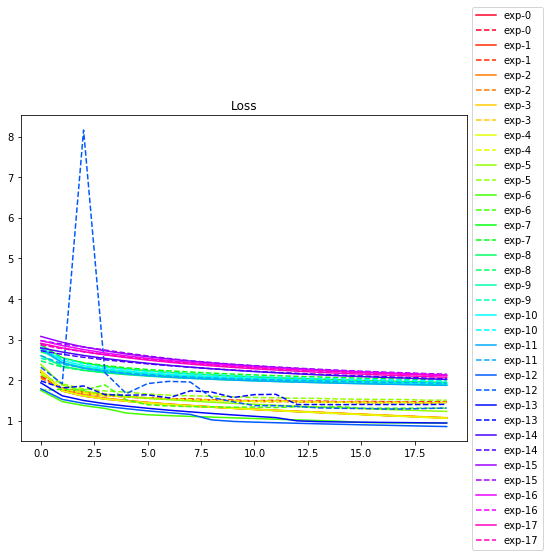

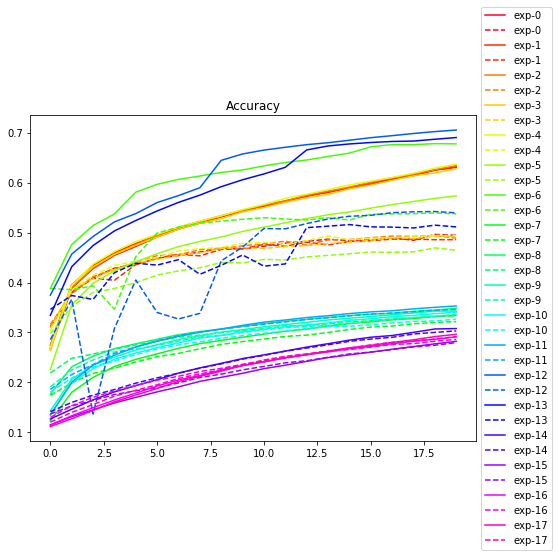

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Answer

從上圖來看，結果（Accuracy）較好的是exp-12､exp-13兩次試驗
用的optimizer為RMSprop

Numbers of exp: 12, reduce_factor: 0.10, reduce_patient: 3
Numbers of exp: 13, reduce_factor: 0.10, reduce_patient: 5